In [1]:
##imports
import pandas as pd
import numpy as np
import cupy as cp
import gzip
import matplotlib.pyplot as plt

In [2]:
def create_df_from_file(images_file_path, labels_file_path):
    images_file = gzip.open(images_file_path,'r')
    labels_file = gzip.open(labels_file_path,'r')
    
    buf = images_file.read(4)
    # verifying 'magic number' at beginning of file, to ensure we are reading properly
    dt = np.dtype(int) #define the magic number datatype as np.int32
    dt = dt.newbyteorder('>') #ensure numpy interprets the data in big endian format per the data docs
    if np.frombuffer(buf, dtype=dt) != 2051: #read the magic number from the images file - docs say it should be 2051
        print("Magic number did not match")
        images_file.close()
        labels_file.close()
        return None
    buf = labels_file.read(4)
    if np.frombuffer(buf, dtype=dt) != 2049: #read the magic number from the labels file - docs say it should be 2049
        print("Magic number did not match")
        images_file.close()
        labels_file.close()
        return None
    
    #The next value in each file should be the number of images
    buf = images_file.read(4)
    num_images = np.frombuffer(buf, dtype=dt)[0]
    buf = labels_file.read(4)
    if num_images != np.frombuffer(buf, dtype=dt)[0]:
        print("File image counts aren't matching")
        images_file.close()
        labels_file.close()
        return None
    
    #next two values in images file should be num rows/cols per image
    buf = images_file.read(4)
    num_rows = np.frombuffer(buf, dtype=dt)[0]
    buf = images_file.read(4)
    num_cols = np.frombuffer(buf, dtype=dt)[0]
    if num_cols != 28 or num_rows != 28:
        print("Row and/or Column count not matching expected value")
        images_file.close()
        labels_file.close()
        return None

    labels = []
    image_dict = {}
    #set datatype for pixels/labels, should be 1 byte, per the docs
    dt = np.dtype(np.uint8)
    dt = dt.newbyteorder('>') #ensure proper endianness
    #iterate across all images
    for i in range(num_images):
        buf = images_file.read(num_rows * num_cols)
        image_dict[i] = np.frombuffer(buf, dtype=dt).astype(np.uint32).flatten() / 255
        #get the label for the image
        buf = labels_file.read(1)
        labels.append(np.frombuffer(buf, dtype=dt).astype(np.uint32)[0])
    #close up our files
    images_file.close()
    labels_file.close()
    
    #make the df
    df = pd.DataFrame.from_dict(image_dict, orient='index')
    df['labels'] = labels
    return df

def show_number(df, index, class_label='labels', row_size=28, col_size=28):
    plt.imshow(np.asarray(df.drop(class_label, axis=1).iloc[index]).reshape(row_size,col_size))

In [3]:
df_test  = create_df_from_file('test-images-idx3-ubyte.gz', 'test-labels-idx1-ubyte.gz')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [4]:
df_train = create_df_from_file('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


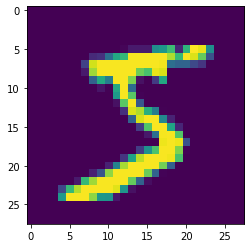

In [5]:
show_number(df_train, 0)

In [6]:
class NeuralNet():
    
    def __init__(self, learning_rate=0.1, hidden_layers=[10,], activation_func_name='relu', max_iter=1000, random_state=None, random_dist="norm_univariate", bias_init_zero=False):
        self.learning_rate=learning_rate
        if len(hidden_layers) < 1:
            raise ValueError('Must have at least 1 hidden layer')
        self.hidden_layers=hidden_layers
        self.activation_func_name=activation_func_name
        self.max_iter=max_iter
        self.random_state=random_state
        self.input_layer_size = -1
        self.num_layers = len(hidden_layers) + 2
        self.wbs = {}
        self.cache = {}
        self.activations = {}
        self.deltas = {}
        self.random_dist = random_dist
        self.bias_init_zero = bias_init_zero
        self.lrelu_param = 0.1 #tunable if we wanted
        
        if self.activation_func_name not in ['relu', 'sigmoid', 'lrelu']:
            raise ValueError('activation_func_name not valid or recognized')
        
    def init_params(self, num_features, num_classes):
        #Create random number generator based of dictated state
        if self.random_state is None:
            rng = cp.random.default_rng()
        else:
            rng = cp.random.default_rng(self.random_state)
        
        #Determine distribution requested and bias selection and initlaize wbs as appropriate
        if self.random_dist == 'norm_univariate':
            if self.bias_init_zero == False:
                #randomly initiaize weights and biases for hidden layers
                i = 1
                # activation layer is 0, hidden layer index is 1 below the hidden layer number
                self.wbs['W'+str(i)] = rng.random(size=(self.hidden_layers[i - 1],num_features)) - 0.5
                self.wbs['b'+str(i)] = rng.random(size=(self.hidden_layers[i - 1], 1)) - 0.5
                i += 1
                while i <= len(self.hidden_layers):
                    self.wbs['W'+str(i)] = rng.random(size=(self.hidden_layers[i - 1],self.hidden_layers[i - 2])) - 0.5
                    self.wbs['b'+str(i)] = rng.random(size=(self.hidden_layers[i - 1], 1)) - 0.5
                    i += 1
                # randomly initalize weights for output layer, with weight size last hidden layers - num_classes
                self.wbs['W'+str(i)] = rng.random(size=(num_classes, self.hidden_layers[-1])) - 0.5
                self.wbs['b'+str(i)] = rng.random(size=(num_classes, 1)) - 0.5
            else:
                #randomly initiaize weights and biases for hidden layers
                i = 1
                # activation layer is 0, hidden layer index is 1 below the hidden layer number
                self.wbs['W'+str(i)] = rng.random(size=(self.hidden_layers[i - 1],num_features)) - 0.5
                self.wbs['b'+str(i)] = cp.zeros(shape=(self.hidden_layers[i - 1], 1))
                i += 1
                while i <= len(self.hidden_layers):
                    self.wbs['W'+str(i)] = rng.random(size=(self.hidden_layers[i - 1],self.hidden_layers[i - 2])) - 0.5
                    self.wbs['b'+str(i)] = cp.zeros(shape=(self.hidden_layers[i - 1], 1))
                    i += 1
                # randomly initalize weights for output layer, with weight size last hidden layers - num_classes
                self.wbs['W'+str(i)] = rng.random(size=(num_classes, self.hidden_layers[-1])) - 0.5
                self.wbs['b'+str(i)] = cp.zeros(shape=(num_classes, 1))
        elif self.random_dist == 'std_norm':
            if self.bias_init_zero == False:
                #randomly initiaize weights and biases for hidden layers
                i = 1
                # activation layer is 0, hidden layer index is 1 below the hidden layer number
                self.wbs['W'+str(i)] = rng.standard_normal(size=(self.hidden_layers[i - 1],num_features))
                self.wbs['b'+str(i)] = rng.standard_normal(size=(self.hidden_layers[i - 1], 1))
                i += 1
                while i <= len(self.hidden_layers):
                    self.wbs['W'+str(i)] = rng.standard_normal(size=(self.hidden_layers[i - 1],self.hidden_layers[i - 2]))
                    self.wbs['b'+str(i)] = rng.standard_normal(size=(self.hidden_layers[i - 1], 1))
                    i += 1
                # randomly initalize weights for output layer, with weight size last hidden layers - num_classes
                self.wbs['W'+str(i)] = rng.standard_normal(size=(num_classes, self.hidden_layers[-1]))
                self.wbs['b'+str(i)] = rng.standard_normal(size=(num_classes, 1))
            else:
                #randomly initiaize weights and biases for hidden layers
                i = 1
                # activation layer is 0, hidden layer index is 1 below the hidden layer number
                self.wbs['W'+str(i)] = rng.standard_normal(size=(self.hidden_layers[i - 1],num_features))
                self.wbs['b'+str(i)] = cp.zeros(shape=(self.hidden_layers[i - 1], 1))
                i += 1
                while i <= len(self.hidden_layers):
                    self.wbs['W'+str(i)] = rng.standard_normal(size=(self.hidden_layers[i - 1],self.hidden_layers[i - 2]))
                    self.wbs['b'+str(i)] = cp.zeros(shape=(self.hidden_layers[i - 1], 1))
                    i += 1
                # randomly initalize weights for output layer, with weight size last hidden layers - num_classes
                self.wbs['W'+str(i)] = rng.standard_normal(size=(num_classes, self.hidden_layers[-1]))
                self.wbs['b'+str(i)] = cp.zeros(shape=(num_classes, 1))
        else:
            raise ValueError('Please select a valid wbs initalization distribution')

    def forward_propagation(self, X):
        i = 1
        #inital layer, uses raw data as 'activation input'
        self.cache['Z'+str(i)] = cp.dot(self.wbs['W'+str(i)], X) + self.wbs['b'+str(i)]
        self.activations['A'+str(i)] = self.activation_func(self.cache['Z'+str(i)])
        #propagate all data up to end
        i += 1
        while i <= len(self.hidden_layers):
            #store preactivation values
            self.cache['Z'+str(i)] = cp.dot(self.wbs['W'+str(i)], self.activations['A'+str(i - 1)]) + self.wbs['b'+str(i)]
            self.activations['A'+str(i)] = self.activation_func(self.cache['Z'+str(i)])
            i+= 1
        
        #output layer uses a different activation func
        self.cache['Z'+str(i)] = cp.dot(self.wbs['W'+str(i)], self.activations['A'+str(i - 1)]) + self.wbs['b'+str(i)]
        self.activations['A'+str(i)] = self.softmax(self.cache['Z'+str(i)])
        
    def get_one_hot_matrix(self, y):
        #use this so we can have a known value to compute cost function: (MSE)
        #get an array that matches our output dimensions filled with zeros
        retval = cp.zeros((int(y.max())+1,y.size))
        #Iterate through the array, setting our labels to 1
        retval[y,cp.arange(y.size)] = 1
        return retval

    def backward_propagation(self, X, y, num_samples):
        actual = self.get_one_hot_matrix(y)
        #calculate error for output layer
        i = len(self.hidden_layers) + 1
        #this is a simplified result of the chain rule using softmax only on the output
        self.deltas['dz'+str(i)] = 2*(self.activations['A'+str(i)] - actual)
        self.deltas['dw'+str(i)] = (1/num_samples) * (cp.matmul(self.deltas['dz'+str(i)], self.activations['A'+str(i-1)].T))
        self.deltas['db'+str(i)] = (1/num_samples) * (cp.sum(self.deltas['dz'+str(i)], axis=1))
        i -= 1
        #propagate error backward
        while i > 1:
            self.deltas['dz'+str(i)] = cp.dot(self.wbs['W'+str(i+1)].T, self.deltas['dz'+str(i+1)]) * self.derivative_func(self.cache['Z'+str(i)])
            self.deltas['dw'+str(i)] = (1/num_samples) * (cp.dot(self.deltas['dz'+str(i)], self.activations['A'+str(i-1)].T))
            self.deltas['db'+str(i)] = (1/num_samples) * cp.sum(self.deltas['dz'+str(i)], axis=1)
            i -= 1
        
        #input layer backprop, need original data at this step
        self.deltas['dz'+str(i)] = cp.dot(self.wbs['W'+str(i+1)].T, self.deltas['dz'+str(i+1)]) * self.derivative_func(self.cache['Z'+str(i)])
        self.deltas['dw'+str(i)] = (1/num_samples) * (cp.dot(self.deltas['dz'+str(i)], X.T))
        self.deltas['db'+str(i)] = (1/num_samples) * (cp.sum(self.deltas['dz'+str(i)], axis=1))

    def update_wbs(self):
        i = 1
        while i <= len(self.hidden_layers) + 1:
            self.wbs['W'+str(i)] = self.wbs['W'+str(i)] - self.learning_rate * self.deltas['dw'+str(i)]
            self.wbs['b'+str(i)] = self.wbs['b'+str(i)] - self.learning_rate * cp.reshape(self.deltas['db'+str(i)], (self.wbs['b'+str(i)].shape[-2],1))
            i += 1

        return
    
    def fit(self, X, y):
        self.init_params(X.shape[-2], len(np.unique(y)))
        self.gd(X, y)
        
    def gd(self, X, y):
        for i in range(self.max_iter):
            self.forward_propagation(X)
            self.backward_propagation(X, y, X.shape[-1])
            self.update_wbs()
            
    def predict(self, X):
        self.forward_propagation(X)
        return np.argmax(self.activations['A'+str(len(self.hidden_layers) + 1)], axis=0)
 
    def activation_func(self, vector):
        if self.activation_func_name == 'relu':
            return self.relu(vector)
        if self.activation_func_name == 'sigmoid':
            return self.sigmoid(vector)
        if self.activation_func_name == 'lrelu':
            return self.lrelu(vector)
        
    def derivative_func(self, vector):
        if self.activation_func_name == 'relu':
            return self.d_relu(vector)
        elif self.activation_func_name == 'sigmoid':
            return self.d_sigmoid(vector)
        elif self.activation_func_name == 'lrelu':
            return self.d_lrelu(vector)
        
    def relu(self, vector):
        return np.maximum(0, vector)
    
    def d_relu(self, vector):
        return vector > 0

    def softmax(self, vector):
        retval = cp.exp(vector - cp.max(vector))
        return retval / retval.sum(axis=0)
    
    def d_sigmoid(self, vector):
        s = self.sigmoid(vector)
        return s * (1 - s)
    
    def sigmoid(self, vector):
        return cp.exp(vector) / (1 + cp.exp(vector))
    
    def lrelu(self, vector):
        return cp.maximum(self.lrelu_param * vector, vector)
    
    def d_lrelu(self, vector):
        retval = cp.ones_like(vector)
        retval[vector < 0] = self.lrelu_param
        return retval
    

In [7]:
X_train = cp.asarray(df_train.drop('labels', axis=1).T)
y_train = cp.asarray(df_train['labels'])

In [8]:
X_test = cp.asarray(df_test.drop('labels', axis=1).T)

In [9]:
def accuracy_score(df, class_label, predictions_label):
    return len(df[df[class_label] == df[predictions_label]]) / len(df)

In [10]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[10])
ntest.fit(X_train, y_train)

In [11]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.8861

In [12]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[15])
ntest.fit(X_train, y_train)

In [13]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [14]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.8999

In [15]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[15], bias_init_zero=True)
ntest.fit(X_train, y_train)

In [16]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [17]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.8956

In [18]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[15], random_dist="std_norm", bias_init_zero=True)
ntest.fit(X_train, y_train)

In [19]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [20]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.6313

In [21]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[15], random_dist="std_norm")
ntest.fit(X_train, y_train)

In [22]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [23]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.6639

In [24]:
ntest = NeuralNet(learning_rate=0.1, max_iter=1500, random_state=3, hidden_layers=[15], random_dist="std_norm",bias_init_zero=True )
ntest.fit(X_train, y_train)

In [25]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [26]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.7817

In [27]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[20])
ntest.fit(X_train, y_train)

In [28]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [29]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.9058

In [30]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[10,10])
ntest.fit(X_train, y_train)

In [31]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [32]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.8753

In [33]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[20,20])
ntest.fit(X_train, y_train)

In [34]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [35]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.902

In [36]:
ntest = NeuralNet(learning_rate=0.05, max_iter=1000, random_state=3, hidden_layers=[20,20,20])
ntest.fit(X_train, y_train)

In [37]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [38]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.9156

In [39]:
ntest = NeuralNet(learning_rate=0.15, max_iter=500, random_state=3, hidden_layers=[20,20,20])
ntest.fit(X_train, y_train)

In [40]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [41]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.9259

In [42]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=3, hidden_layers=[20,20,20])
ntest.fit(X_train, y_train)

In [43]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [44]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.9088

In [45]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=5, hidden_layers=[20,20])
ntest.fit(X_train, y_train)

In [46]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [47]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.8978

In [48]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=5, hidden_layers=[20,20], activation_func_name='sigmoid')
ntest.fit(X_train, y_train)

In [49]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [50]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.7416

In [51]:
ntest = NeuralNet(learning_rate=0.1, max_iter=500, random_state=5, hidden_layers=[20,20], activation_func_name='lrelu')
ntest.fit(X_train, y_train)

In [52]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [53]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.9076

In [54]:
from sklearn import svm

In [57]:
svm_model = svm.SVC() #uses rbf by default, which is what I want

In [62]:
X_train = df_train.drop('labels', axis=1).T
y_train = df_train['labels']

In [63]:
svm_model.fit(X_train.T, y_train)

SVC()

In [64]:
X_test = df_test.drop('labels', axis=1)
X_test = X_test.drop('predictions', axis = 1).T

In [65]:
predictions = svm_model.predict(X_test.T)
df_test['predictions'] = predictions
accuracy_score(df_test, 'labels', 'predictions')

0.9792

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
model_logit = LogisticRegression(max_iter=10000)

In [68]:
model_logit.fit(X_train.T, y_train)#oh wow, so fast

LogisticRegression(max_iter=10000)

In [69]:
X_test = df_test.drop('labels', axis=1)
X_test = X_test.drop('predictions', axis = 1).T

In [70]:
predictions = model_logit.predict(X_test.T)
df_test['predictions'] = predictions
accuracy_score(df_test, 'labels', 'predictions')

0.9256

In [71]:
X_train = cp.asarray(df_train.drop('labels', axis=1).T)
y_train = cp.asarray(df_train['labels'])

In [73]:
ntest = NeuralNet(learning_rate=0.1, max_iter=5000, random_state=3, hidden_layers=[90,60,40], activation_func_name='lrelu', bias_init_zero=True)
ntest.fit(X_train, y_train)

In [74]:
X_test = df_test.drop('labels', axis=1)
X_test = cp.asarray(X_test.drop('predictions', axis = 1).T)

In [75]:
predictions = ntest.predict(X_test)
df_test['predictions'] = cp.asnumpy(predictions)
accuracy_score(df_test, 'labels', 'predictions')

0.9589